# <center> **Kaggle’s Spaceship Titanic Competition**
# <center> **Machine Learning**

# **Libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score

import functions
import importlib
importlib.reload(functions)

import time

# **Load Data**

In [2]:
data = pd.read_csv(
    r"C:\Users\Dell\Documents\AI\Titanic\Data\Data\data.csv",
    index_col=False
)

train = pd.read_csv(
    r"C:\Users\Dell\Documents\AI\Titanic\Data\train.csv",
    index_col=False
)

test = pd.read_csv(
    r"C:\Users\Dell\Documents\AI\Titanic\Data\test.csv",
    index_col=False
)


random_state = 101
target = 'Transported'

# **Machine Learning**

## **Models**

**1. Logistic Regression:** This model uses Maximum Likelihood Estimation to fit a sigmoid-curve on the target variable distribution. 

**2. K-Nearest Neighbors (KNN):** This model is a simple and effective algorithm that selects the majority class of the k-nearest neighbours.

**3. Random Forest (RF):** This model is an ensemble of decision trees The diverse forests of uncorrelated trees is more robust towards change in data and carries its prediction accuracy to new data. 

**4. Extreme Gradient Boosting (XGBoost):** This model is made of an ensemble of decision-trees. It uses extreme gradient boosting when optimising its objective function. It usually is very slow.

**5. Light Gradient Boosting Machine (LGBM):** This model works essentially the same as XGBoost but with a lighter boosting technique. It usually is significantly faster.

**6. Categorical Boosting (CatBoost):** This model is based on gradient boosted decision trees. It tries to take the best of XGBoost and LGBM.

## **Split Data Back to Train and Test**

In [3]:
train=data[data['PassengerId'].isin(train['PassengerId'].values)].copy()
test=data[data['PassengerId'].isin(test['PassengerId'].values)].copy()

### **Section Summary**

> *  **data.csv:** data.csv was created in the previous section to make Feature Engineering easier. </BR>
> *  **train.csv:** Extracted from data.csv. </BR>
> *  **test.csv:** Extracted from data.csv. </BR>

## **Drop Unneeded Features**

In [4]:
train.drop(['Group', 'CabinNumber'], axis=1, inplace=True)
test.drop(['Group', 'CabinNumber'], axis=1, inplace=True)

### **Section Summary**

> *  **1. PassengerId:** DELETED </BR>
> *  **2. Group:** DELETED </BR>
> *  **3. CabinNumber:** DELETED

## **Log Transform**

In [5]:
columns_to_transform = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalExpenditure']  # Replace with your actual column names

for col in columns_to_transform:
    train = functions.log_transform(train, col)
    test = functions.log_transform(test, col)

### **Section Summary**

> *  **Expenditure Features:** Luxury expenditure features are skewed by outliers. </BR>
> *  **Log Transform:** Log Transfrom decreases skew in distributions with there are outliers.

## **Column Separation**

In [6]:
numerical_cols = [cname for cname in train.columns if train[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in train.columns if train[cname].dtype in ["object", "bool"]]
categorical_cols.remove(target)

### **Section Summary**

> *  **Column Separation:** Numerical columns are separated from categorical columns to do scaling and encoding. </BR>
> *  **Numerical Columns:** int64 and float64</BR>
> *  **Categorical Columns:** object and bool </BR>

## **Train Test Split**

In [7]:
X = train.drop(target, axis=1)
y = train[target]
y = y.astype(bool)


X, y = shuffle(X, y, random_state=random_state)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)

## **Pre-Processing**

In [8]:
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor  = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)],
        remainder='passthrough')

## **Modeling**

In [12]:
lg_model = LogisticRegression(random_state=random_state, max_iter=5000)
lg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lg', lg_model)
])

knn_model = KNeighborsClassifier()
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', knn_model)
])  

rf_model = RandomForestClassifier(random_state=random_state)
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('random_forest', rf_model)
])

xgb_model = XGBClassifier()
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgb', xgb_model)
])

lgbm_model = LGBMClassifier(random_state=random_state, verbose=0)
lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lgbm', lgbm_model)
])

catboost_model = CatBoostClassifier(random_state=random_state, verbose=0)
catboost_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('catboost', catboost_model)
])  


pipelines = {
    "Logistic Regression": lg_pipeline,
    "KNN": knn_pipeline,
    "Random Forest": rf_pipeline,
    "XGBoost": xgb_pipeline,
    "LightGBM": lgbm_pipeline,
    "CatBoost": catboost_pipeline,
}


for name, pipeline in pipelines.items():
    start_time = time.time()  
    scores = cross_val_score(pipeline, X, y, cv=10)
    end_time = time.time()  
    elapsed_time = (end_time - start_time)/60  
    
    print(f"{name}: {scores.mean():.2f} ({elapsed_time:.2f} minutes)")

Logistic Regression: 0.77 (4.03 minutes)
KNN: 0.75 (0.74 minutes)
Random Forest: 0.78 (9.61 minutes)
XGBoost: 0.80 (4.49 minutes)
LightGBM: 0.80 (0.54 minutes)
CatBoost: 0.81 (22.02 minutes)


### **Insights**

>  **1. Models Tested:** These 6 models were tested: Logistic Regression, KNN, Random Forest, XGBoost, LightGBM, and CatBoost </BR>
>  **2. Lower Performance:** Logistic Regression, KNN and Random Forest produced mediocre results. </BR>
>  **3. Higher Performance:** The three boosting models, XGBoost, LightGBM and CatBoost performed at the standard level of 80%

## **Grid Search CV**

### **CatBoost**

In [ ]:
start_time = time.time()  

param_grid = [
    {
        'classifier__n_estimators': [50, 100, 150, 200],
        'classifier__max_depth': [4, 8, 12],
        'classifier__learning_rate': [0.01, 0.1, 0.2]
    }
]


pipeline = Pipeline([
    ('preprocessor', preprocessor),         
    ('classifier', CatBoostClassifier(random_state=random_state, verbose = 0)) 
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')


grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(grid_search.best_score_))

test_score = grid_search.score(X_test, y_test)
print("Test set accuracy: {:.2f}".format(test_score))

end_time = time.time()  
elapsed_time = (end_time - start_time)/60 
print(f"Elapsed Time: {elapsed_time:.2f} minutes")

Best parameters found:  {'classifier__learning_rate': 0.2, 'classifier__max_depth': 4, 'classifier__n_estimators': 100}
Best cross-validation accuracy: 0.81
Test set accuracy: 0.78
Elapsed Time: 71.23 minutes


In [9]:
start_time = time.time()  

pipeline = Pipeline([
    ('preprocessor', preprocessor),         
    ('classifier', CatBoostClassifier(verbose=0, random_state=random_state, learning_rate=0.2, max_depth=4, n_estimators=100)) 
])

cross_val_accuracy = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy').mean()
print("Best cross-validation accuracy: {:.2f}".format(cross_val_accuracy))

pipeline.fit(X_train, y_train)
test_score = pipeline.score(X_test, y_test)
print("Test set accuracy: {:.2f}".format(test_score))

end_time = time.time()  
elapsed_time = (end_time - start_time)/60 
print(f"Elapsed Time: {elapsed_time:.2f} minutes")

Best cross-validation accuracy: 0.81
Test set accuracy: 0.78
Elapsed Time: 2.43 minutes


### **Classification Report**

In [10]:
X_test = X_test
y_test = y_test
pipeline = pipeline

y_predict = functions.create_classification_report(pipeline, X_test, y_test)

              precision    recall  f1-score   support

       False       0.79      0.76      0.78       863
        True       0.77      0.81      0.79       876

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739



### **Confusion Matrix**

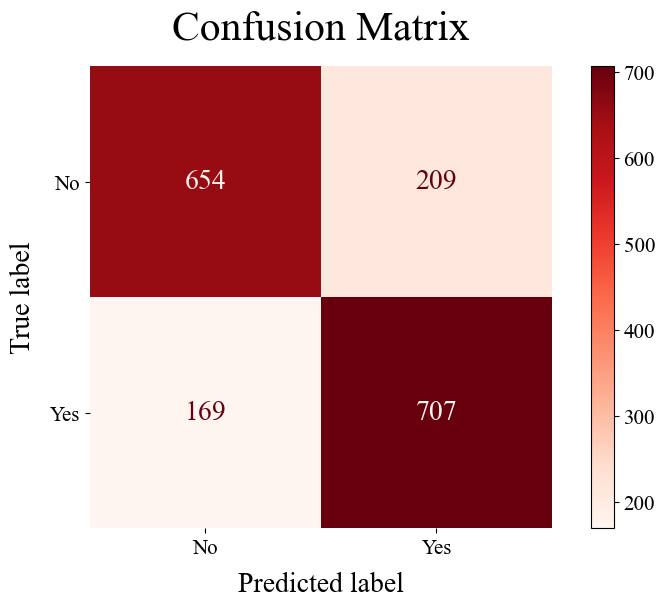

In [11]:
pipeline = pipeline
X_test = X_test
y_test = y_test
color = plt.cm.Reds
title = 'Confusion Matrix'

functions.create_confusion_matrix(pipeline, X_test, y_test, color, title)

### **Feature Importance**

In [98]:
pipeline = pipeline
classifier = 'classifier'
preprocessor = 'preprocessor'

functions.create_feature_importance(pipeline, classifier, preprocessor)

                       Feature  Importance
8        num__TotalExpenditure   13.475349
6                     num__Spa   11.773403
7                  num__VRDeck    9.723334
9             num__Expenditure    9.548461
12       cat__HomePlanet_Earth    8.160168
...                        ...         ...
757    cat__LastName_Folkshbox    0.000000
756       cat__LastName_Folhal    0.000000
755   cat__LastName_Folemonley    0.000000
754     cat__LastName_Foledges    0.000000
2166  cat__LastName_Youngrayes    0.000000

[2167 rows x 2 columns]


### **Area Under the Curve (AUC)**

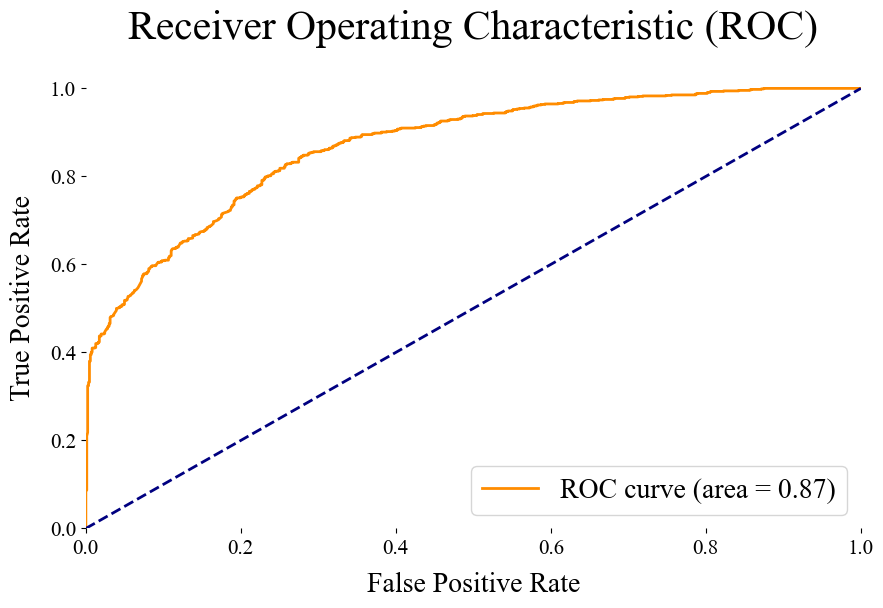

In [11]:
pipeline = pipeline
X_test = X_test
y_test = y_test

functions.create_ROC(pipeline, X_test, y_test)

### **Insights**

>  **1. Cross Validation Accuracy:** 81% accuracy.</BR>
>  **2. Test Set Accuracy:** 78% accuracy. </BR>
>  **3. Slowest Model:** 80 minutes for GridSearch CV and 1 minute to run. </BR>
>  **4. Top 3 Features:** TotalExpenditure, Spa, VRDeck </BR>
>  **5. AUC:** 0.88

### **XGB**

In [37]:
start_time = time.time()  

param_grid = [
    {
        'classifier__n_estimators': [50, 100, 150, 200],
        'classifier__max_depth': [4, 8, 12],
        'classifier__learning_rate': [0.01, 0.1, 0.2]
    }
]   

pipeline = Pipeline([
    ('preprocessor', preprocessor),         
    ('classifier', XGBClassifier(random_state=random_state)) 
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')


grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(grid_search.best_score_))

test_score = grid_search.score(X_test, y_test)
print("Test set accuracy: {:.2f}".format(test_score))

end_time = time.time()  
elapsed_time = (end_time - start_time)/60 
print(f"Elapsed Time: {elapsed_time:.2f} minutes")

Best parameters found:  {'classifier__learning_rate': 0.2, 'classifier__max_depth': 4, 'classifier__n_estimators': 100}
Best cross-validation accuracy: 0.81
Test set accuracy: 0.79
Elapsed Time: 21.79 minutes


In [12]:
start_time = time.time()  

pipeline = Pipeline([
    ('preprocessor', preprocessor),         
    ('classifier', XGBClassifier(random_state=random_state, learning_rate=0.2, max_depth=4, n_estimators=100)) 
])

cross_val_accuracy = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy').mean()
print("Best cross-validation accuracy: {:.2f}".format(cross_val_accuracy))

pipeline.fit(X_train, y_train)
test_score = pipeline.score(X_test, y_test)
print("Test set accuracy: {:.2f}".format(test_score))

end_time = time.time()  
elapsed_time = (end_time - start_time)/60 
print(f"Elapsed Time: {elapsed_time:.2f} minutes")

Best cross-validation accuracy: 0.81
Test set accuracy: 0.79
Elapsed Time: 1.32 minutes


### **Classification Report**

In [13]:
X_test = X_test
y_test = y_test
pipeline = pipeline

y_predict = functions.create_classification_report(pipeline, X_test, y_test)

              precision    recall  f1-score   support

       False       0.80      0.76      0.78       863
        True       0.78      0.81      0.79       876

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



### **Confusion Matrix**

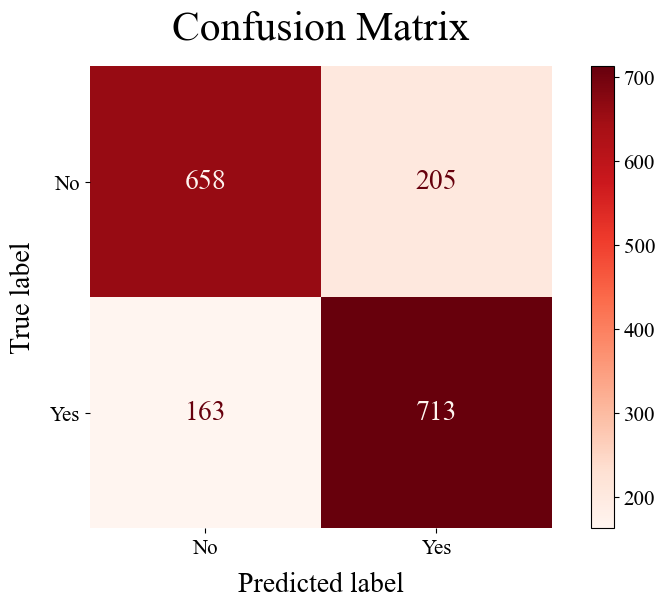

In [14]:
pipeline = pipeline
X_test = X_test
y_test = y_test
color = plt.cm.Reds
title = 'Confusion Matrix'

functions.create_confusion_matrix(pipeline, X_test, y_test, color, title)

### **Feature Importance**

In [208]:
pipeline = pipeline
classifier = 'classifier'
preprocessor = 'preprocessor'

functions.create_feature_importance(pipeline, classifier, preprocessor)

                       Feature  Importance
9             num__Expenditure    0.690840
12       cat__HomePlanet_Earth    0.059276
28        cat__CryoSleep_False    0.030439
19            cat__CabinDeck_E    0.014842
5            num__ShoppingMall    0.013669
...                        ...         ...
740     cat__LastName_Flesping    0.000000
739         cat__LastName_Fles    0.000000
738     cat__LastName_Flemaney    0.000000
737        cat__LastName_Flell    0.000000
2166  cat__LastName_Youngrayes    0.000000

[2167 rows x 2 columns]


### **Area Under the Curve (AUC)**

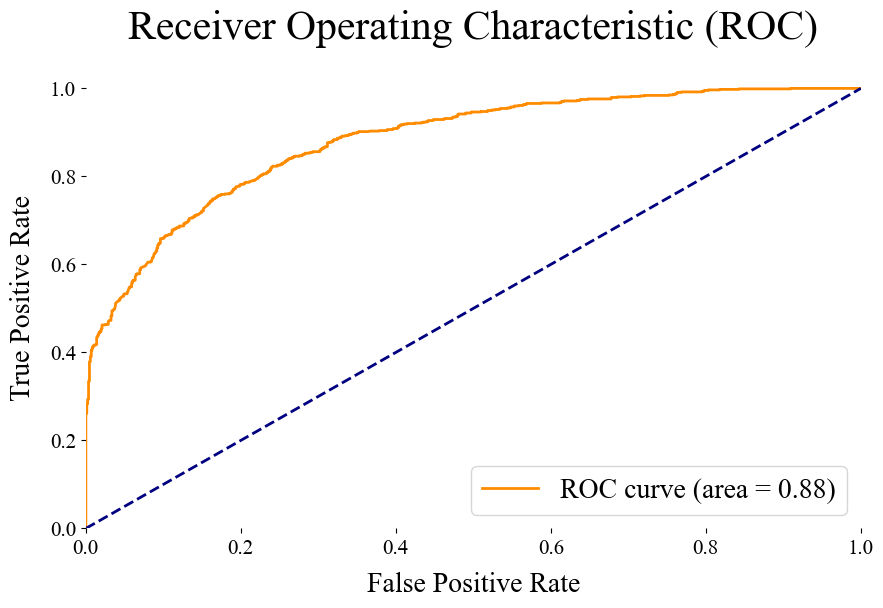

In [209]:
pipeline = pipeline
X_test = X_test
y_test = y_test

functions.create_ROC(pipeline, X_test, y_test)

### **Insights**

>  **1. Cross Validation Accuracy:** 81% accuracy.</BR>
>  **2. Test Set Accuracy:** At 78% accuracy, it almost reached the 80% standard. </BR>
>  **3. Medium Speed:** 20 minutes for GridSearch CV and 1 minute to run.</BR>
>  **4. Top 3 Features:** Expenditure, HomePlanet, CryoSleep </BR>
>  **5. AUC:** 0.88

### **LGBM**

In [33]:
start_time = time.time()  

param_grid = [
    {
        'classifier__n_estimators': [50, 100, 150, 200],
        'classifier__max_depth': [4, 8, 12],
        'classifier__learning_rate': [0.01, 0.1, 0.2]
    }
]


pipeline = Pipeline([
    ('preprocessor', preprocessor),         
    ('classifier', LGBMClassifier(random_state=random_state, verbose = -1)) 
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')


grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(grid_search.best_score_))

test_score = grid_search.score(X_test, y_test)
print("Test set accuracy: {:.2f}".format(test_score))

end_time = time.time()  
elapsed_time = (end_time - start_time)/60 
print(f"Elapsed Time: {elapsed_time:.2f} minutes")

Best parameters found:  {'classifier__learning_rate': 0.1, 'classifier__max_depth': 4, 'classifier__n_estimators': 150}
Best cross-validation accuracy: 0.81
Test set accuracy: 0.79
Elapsed Time: 2.12 minutes


In [16]:
start_time = time.time()  

pipeline = Pipeline([
    ('preprocessor', preprocessor),         
    ('classifier', LGBMClassifier(random_state=random_state, n_estimators=150, max_depth=4, learning_rate=0.1, verbose = -1)) 
])

cross_val_accuracy = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy').mean()
print("Best cross-validation accuracy: {:.2f}".format(cross_val_accuracy))

pipeline.fit(X_train, y_train)
test_score = pipeline.score(X_test, y_test)
print("Test set accuracy: {:.2f}".format(test_score))

end_time = time.time()  
elapsed_time = (end_time - start_time)/60 
print(f"Elapsed Time: {elapsed_time:.2f} minutes")

Best cross-validation accuracy: 0.81
Test set accuracy: 0.79
Elapsed Time: 0.15 minutes


### **Classification Report**

In [17]:
X_test = X_test
y_test = y_test
pipeline = pipeline

y_predict = functions.create_classification_report(pipeline, X_test, y_test)

              precision    recall  f1-score   support

       False       0.81      0.76      0.78       863
        True       0.78      0.82      0.80       876

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



### **Confusion Matrix**

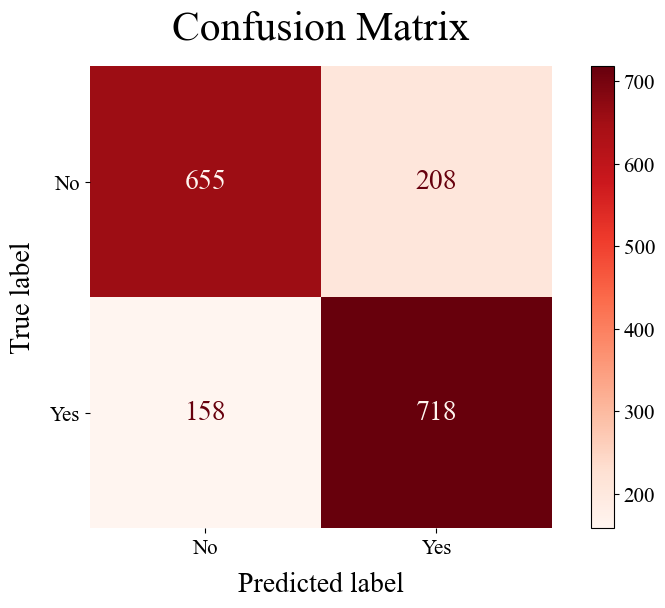

In [18]:
pipeline = pipeline
X_test = X_test
y_test = y_test
color = plt.cm.Reds
title = 'Confusion Matrix'

functions.create_confusion_matrix(pipeline, X_test, y_test, color, title)

### **Feature Importance**

In [106]:
pipeline = pipeline
classifier = 'classifier'
preprocessor = 'preprocessor'

functions.create_feature_importance(pipeline, classifier, preprocessor)

                       Feature  Importance
6                     num__Spa         223
7                  num__VRDeck         210
4               num__FoodCourt         201
8        num__TotalExpenditure         178
2                     num__Age         148
...                        ...         ...
738     cat__LastName_Flemaney           0
737        cat__LastName_Flell           0
736          cat__LastName_Fle           0
735       cat__LastName_Flatic           0
2166  cat__LastName_Youngrayes           0

[2167 rows x 2 columns]


### **Area Under the Curve (AUC)**

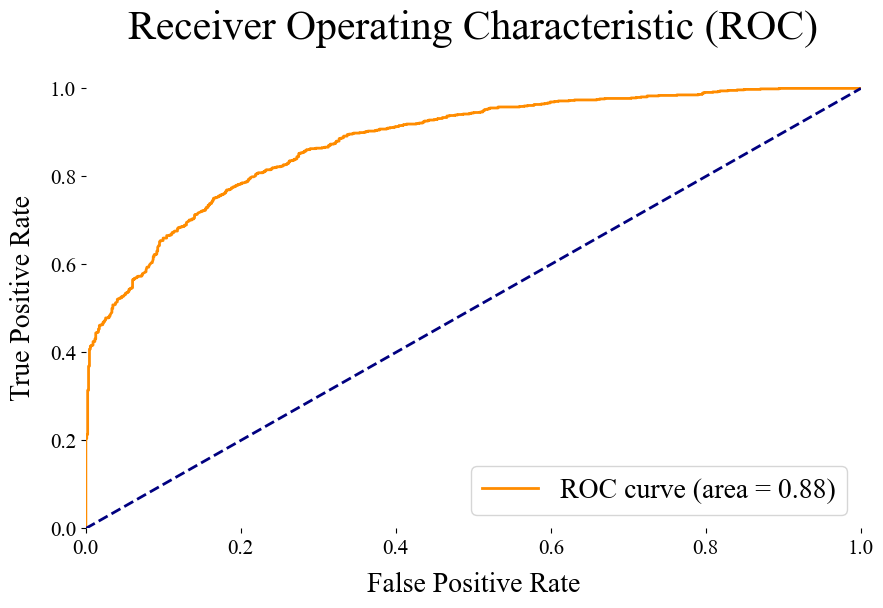

In [19]:
pipeline = pipeline
X_test = X_test
y_test = y_test

functions.create_ROC(pipeline, X_test, y_test)

### **Insights**

>  **1. Cross Validation Accuracy:** 81% accuracy.</BR>
>  **2. Test Set Accuracy:** 79% accuracy. </BR>
>  **3. Fastest Model:** 2 minutes for GridSearch CV and 3 seconds to run. </BR>
>  **4. Top 3 Features:** Spa, VRDeck, FoodCourt </BR>
>  **5. AUC:** 0.88

# **Submission File**

In [33]:
predictions = pipeline.predict(test)

In [35]:
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Transported': predictions
})

submission.to_csv(r"C:\Users\Dell\Documents\AI\Titanic\Data\Data\submission.csv", index=False)

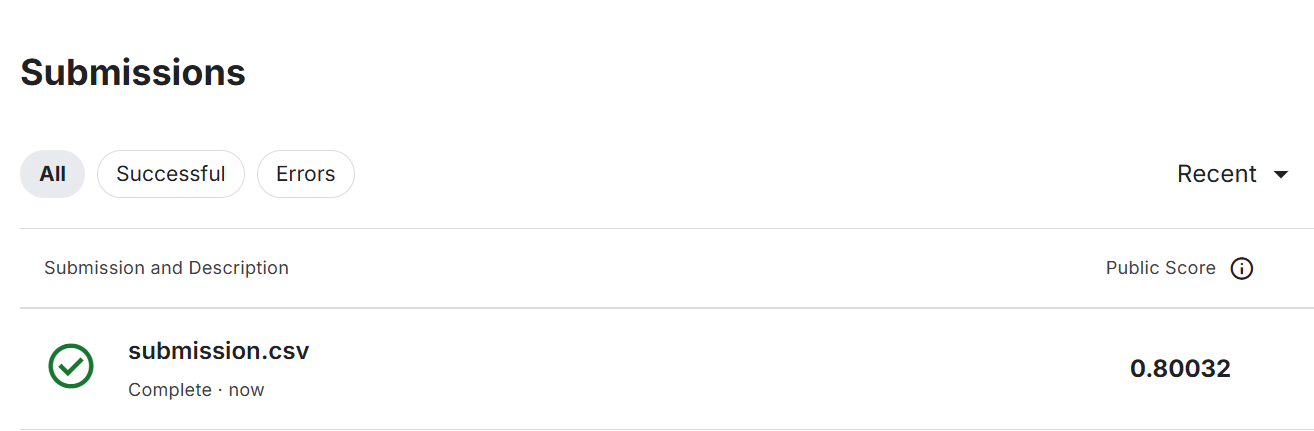